# 1. Introduction & Setup

## NASA C-MAPSS Turbofan Engine Degradation - Exploratory Data Analysis

## Dataset Overview
The Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dataset 
contains run-to-failure simulations of turbofan engines under various operating conditions.

**Goal**: Predict Remaining Useful Life (RUL) of engines based on sensor readings.

**Dataset Details**:
- 4 sub-datasets (FD001-FD004) with varying complexity
- 21 sensor measurements per time cycle (column 6 - 26)
- 3 operational settings (column 3 - 6)
- Different time, in cycles (column 2)
- Multiple engines per dataset (column 1 for unit number)
- Each dataset consists of mulitple multivariate time series and is devided into training and testing subset
- The data can be considered to be from a fleet of enginges of the same type. For further information see readme.txt of dataset. 


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ipynbname
from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

#todo: find cleaner solution for accessing root folder
notebook_path = ipynbname.path()
notebook_path_parent = notebook_path.parent
notebook_root_path = notebook_path_parent.parent
DATA_PATH = Path(notebook_root_path) / "data/CMAPSSData"

print(f"Data directory: {DATA_PATH}")
print(f"Directory exists: {DATA_PATH.exists()}")

Data directory: /home/solaris/solaris-labs/cmapss_predict_maint_mvp/data/CMAPSSData
Directory exists: True


# 2. Data Loading
- Load all 4 datasets (train_FD001-004, test_FD001-004, RUL_FD001-004)
- Understand file structure
- Add column names (unit_number, time_cycles, op_setting_1-3, sensor_1-21)
- Display basic info (shape, dtypes, head)

In [ ]:
"""
The dataset files are space-separated text files without headers.
We need to define column names and load all datasets.
"""

# Define column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

print(f"Total columns: {len(col_names)}")
print(f"Column names: {col_names}\n")

# Function to load data
def load_cmapss_data(filename, data_path=DATA_PATH):
    """Load C-MAPSS dataset file"""
    filepath = data_path / filename
    df = pd.read_csv(filepath, sep='\s+', header=None, names=col_names)
    return df

# Load training datasets
train_fd001 = load_cmapss_data('train_FD001.txt')
train_fd002 = load_cmapss_data('train_FD002.txt')
train_fd003 = load_cmapss_data('train_FD003.txt')
train_fd004 = load_cmapss_data('train_FD004.txt')

# Load test datasets
test_fd001 = load_cmapss_data('test_FD001.txt')
test_fd002 = load_cmapss_data('test_FD002.txt')
test_fd003 = load_cmapss_data('test_FD003.txt')
test_fd004 = load_cmapss_data('test_FD004.txt')

# Load RUL (ground truth for test sets)
rul_fd001 = pd.read_csv(DATA_PATH / 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
rul_fd002 = pd.read_csv(DATA_PATH / 'RUL_FD002.txt', sep='\s+', header=None, names=['RUL'])
rul_fd003 = pd.read_csv(DATA_PATH / 'RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])
rul_fd004 = pd.read_csv(DATA_PATH / 'RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])

print("✓ All datasets loaded successfully!\n")

# Display basic info for FD001 (our focus dataset)
print("=" * 80)
print("TRAIN FD001 - Basic Information")
print("=" * 80)
print(f"Shape: {train_fd001.shape}")
print(f"Memory usage: {train_fd001.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

print("First 5 rows:")
print(train_fd001.head())

print("\nData types:")
print(train_fd001.dtypes.value_counts())

#TODO: If basic dataset statistics printed: add short explanation of dataset statistics
#print("\nBasic statistics:")
#print(train_fd001.describe().round(2))

Total columns: 26
Column names: ['unit_number', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

✓ All datasets loaded successfully!

TRAIN FD001 - Basic Information
Shape: (20631, 26)
Memory usage: 4.09 MB

First 5 rows:
   unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1            1       -0.0007       -0.0004         100.0   
1            1            2        0.0019       -0.0003         100.0   
2            1            3       -0.0043        0.0003         100.0   
3            1            4        0.0007        0.0000         100.0   
4            1            5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  se

# 3. Dataset Overview
- Summary statistics for each dataset
- Number of engines per dataset
- Cycle length distribution per engine
- Compare complexity across FD001-FD004 (operating conditions, fault modes)
- Decision: Which dataset to focus on (recommend FD001 - simplest)

C-MAPSS Datasets Comparison
Dataset  Train Samples  Test Samples  Train Engines  Test Engines  Operating Conditions  Fault Modes
  FD001          20631         13096            100           100                     1            1
  FD002          53759         33991            260           259                     6            1
  FD003          24720         16596            100           100                     1            2
  FD004          61249         41214            249           248                     6            2


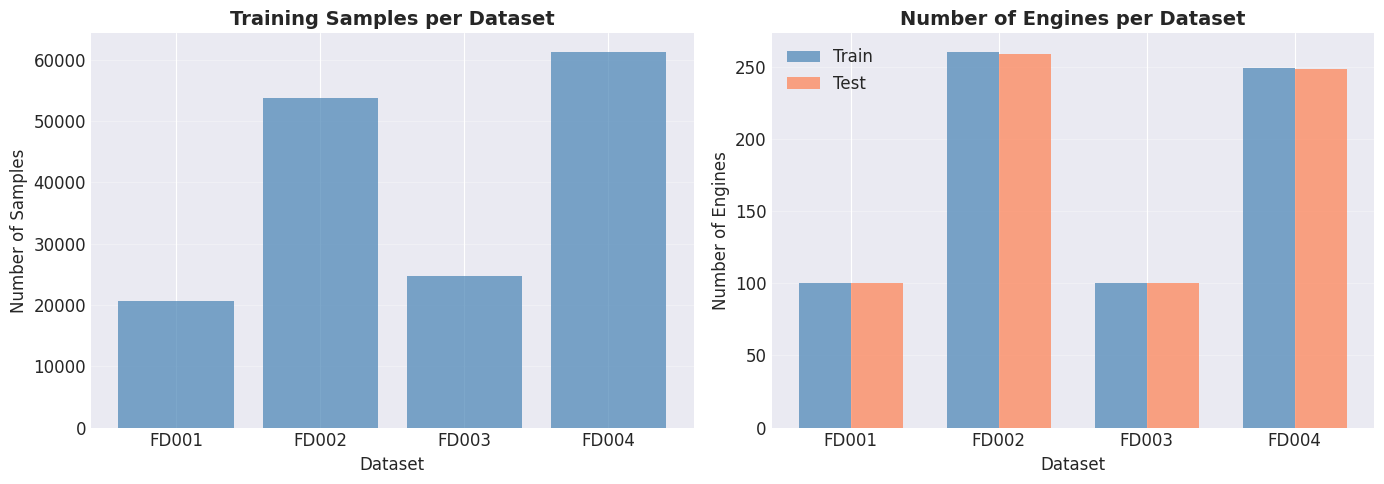


Cycle Length Statistics (Training Data)

FD001:
  Mean: 206.3 cycles
  Std:  46.3 cycles
  Min:  128 cycles
  Max:  362 cycles
  Median: 199.0 cycles

FD002:
  Mean: 206.8 cycles
  Std:  46.8 cycles
  Min:  128 cycles
  Max:  378 cycles
  Median: 199.0 cycles

FD003:
  Mean: 247.2 cycles
  Std:  86.5 cycles
  Min:  145 cycles
  Max:  525 cycles
  Median: 220.5 cycles

FD004:
  Mean: 246.0 cycles
  Std:  73.1 cycles
  Min:  128 cycles
  Max:  543 cycles
  Median: 234.0 cycles


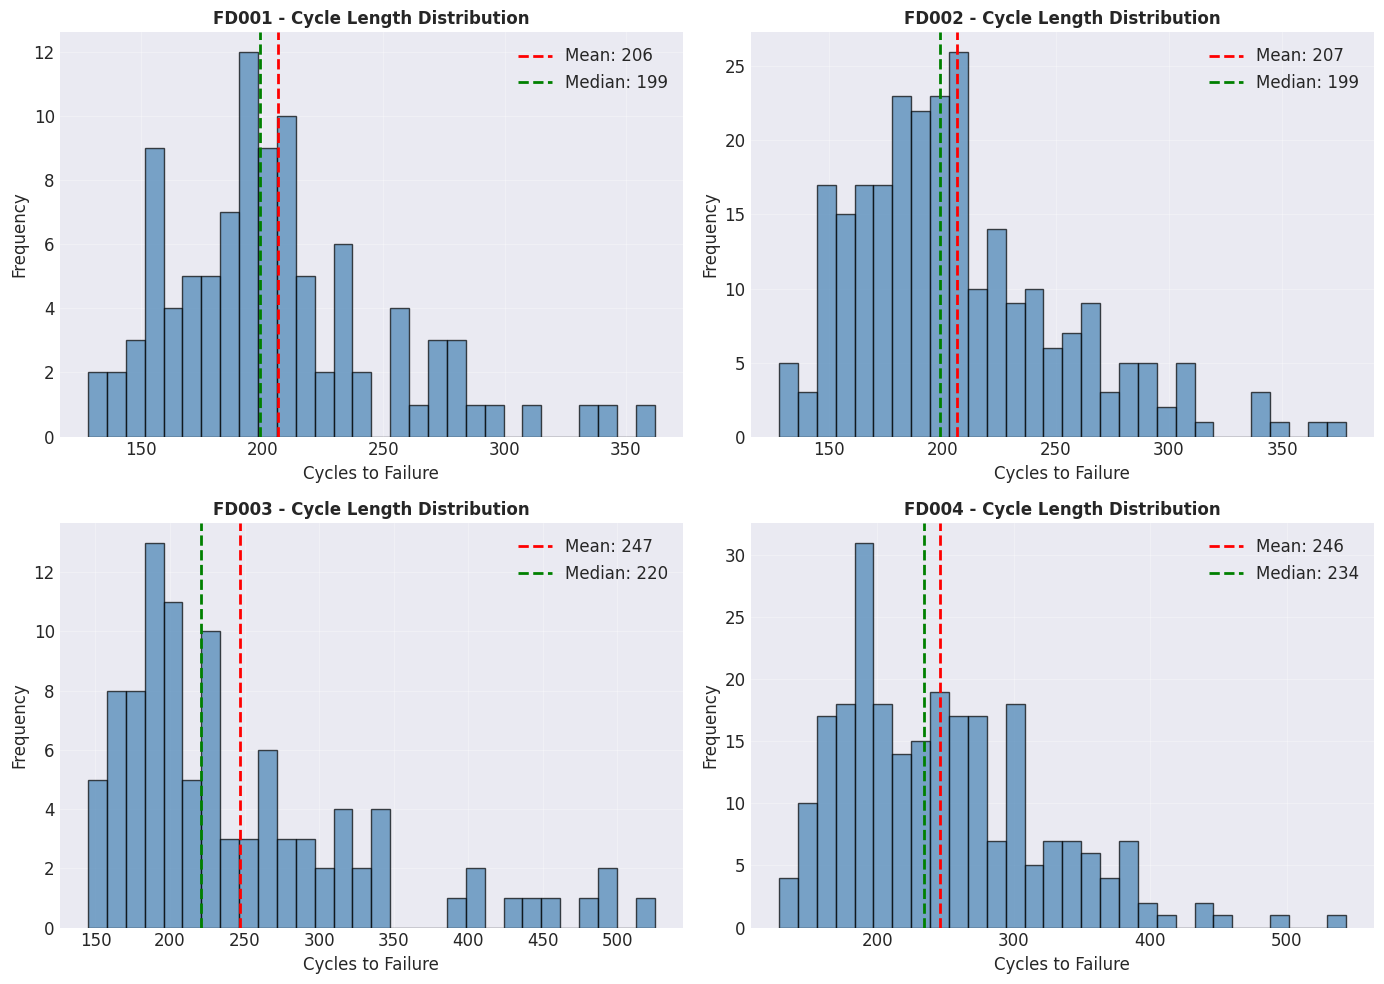


DECISION: Focus on FD001
Reasons:
✓ Simplest dataset (1 operating condition, 1 fault mode)
✓ Good for MVP and initial model development
✓ Most commonly used in research papers (easy to benchmark)
✓ Can expand to FD002-004 later for more complex scenarios


In [17]:
"""
Compare all 4 datasets to understand their complexity and decide which to focus on.
"""

# Create summary dataframe
datasets_info = {
    'Dataset': ['FD001', 'FD002', 'FD003', 'FD004'],
    'Train Samples': [len(train_fd001), len(train_fd002), len(train_fd003), len(train_fd004)],
    'Test Samples': [len(test_fd001), len(test_fd002), len(test_fd003), len(test_fd004)],
    'Train Engines': [train_fd001['unit_number'].nunique(), 
                      train_fd002['unit_number'].nunique(),
                      train_fd003['unit_number'].nunique(), 
                      train_fd004['unit_number'].nunique()],
    'Test Engines': [test_fd001['unit_number'].nunique(), 
                     test_fd002['unit_number'].nunique(),
                     test_fd003['unit_number'].nunique(), 
                     test_fd004['unit_number'].nunique()],
    'Operating Conditions': [1, 6, 1, 6],
    'Fault Modes': [1, 1, 2, 2]
}

df_summary = pd.DataFrame(datasets_info)
print("=" * 80)
print("C-MAPSS Datasets Comparison")
print("=" * 80)
print(df_summary.to_string(index=False))

# Visualize dataset sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training samples
axes[0].bar(df_summary['Dataset'], df_summary['Train Samples'], color='steelblue', alpha=0.7)
axes[0].set_title('Training Samples per Dataset', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xlabel('Dataset')
axes[0].grid(axis='y', alpha=0.3)

# Number of engines
x = np.arange(len(df_summary))
width = 0.35
axes[1].bar(x - width/2, df_summary['Train Engines'], width, label='Train', color='steelblue', alpha=0.7)
axes[1].bar(x + width/2, df_summary['Test Engines'], width, label='Test', color='coral', alpha=0.7)
axes[1].set_title('Number of Engines per Dataset', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Engines')
axes[1].set_xlabel('Dataset')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_summary['Dataset'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze cycle lengths
def get_cycle_stats(df):
    """Get cycle length statistics per engine"""
    cycle_lengths = df.groupby('unit_number')['time_cycles'].max()
    return {
        'mean': cycle_lengths.mean(),
        'std': cycle_lengths.std(),
        'min': cycle_lengths.min(),
        'max': cycle_lengths.max(),
        'median': cycle_lengths.median()
    }

print("\n" + "=" * 80)
print("Cycle Length Statistics (Training Data)")
print("=" * 80)

for name, df in [('FD001', train_fd001), ('FD002', train_fd002), 
                 ('FD003', train_fd003), ('FD004', train_fd004)]:
    stats = get_cycle_stats(df)
    print(f"\n{name}:")
    print(f"  Mean: {stats['mean']:.1f} cycles")
    print(f"  Std:  {stats['std']:.1f} cycles")
    print(f"  Min:  {stats['min']} cycles")
    print(f"  Max:  {stats['max']} cycles")
    print(f"  Median: {stats['median']:.1f} cycles")

# Visualize cycle length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

datasets = [
    ('FD001', train_fd001),
    ('FD002', train_fd002),
    ('FD003', train_fd003),
    ('FD004', train_fd004)
]

for idx, (name, df) in enumerate(datasets):
    cycle_lengths = df.groupby('unit_number')['time_cycles'].max()
    
    axes[idx].hist(cycle_lengths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(cycle_lengths.mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {cycle_lengths.mean():.0f}')
    axes[idx].axvline(cycle_lengths.median(), color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {cycle_lengths.median():.0f}')
    axes[idx].set_title(f'{name} - Cycle Length Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cycles to Failure')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("DECISION: Focus on FD001")
print("=" * 80)
print("Reasons:")
print("✓ Simplest dataset (1 operating condition, 1 fault mode)")
print("✓ Good for MVP and initial model development")
print("✓ Most commonly used in research papers (easy to benchmark)")
print("✓ Can expand to FD002-004 later for more complex scenarios")

#### Some interpretation on data charactersitcs

1. **Mean vs. Median**
- If mean >> median → Some engines last much longer (right skew)
- If mean << median → Some engines fail very early (left skew)
- If mean ≈ median → Symmetric distribution (normal-ish)

2. **Variability**: 
- High std → Engines fail at very different times (unpredictable)
- Low std → More consistent failure patterns (easier to model)
- #TODO: When is a std high/low?

3. **Planning**:

*Usecase*: Managing an airline fleet with 100 turbofan engines. We need to plan, when to schedule a maintenance, how many spare parts to stock and how many technicians to have on standby. From this we know worst case and best case scenario and can calculate the budget - when on average we have to exchange the engines and how much this will cost for a year. 

- Min cycle length → Worst case scenario (128 cycles)
- Max cycle length → Best case scenario (287 cycles)
- Mean/Median → Expected lifetime for planning maintenance

4. **Model Training**:
- Short cycles (< 150) → Less training data per engine
- Long cycles (> 250) → More data, better degradation signals
- Distribution affects how you split train/validation sets

*To consider*: If dataset has unequal distribution of short, medium and long cycle legths and we randomly split, we might get a nuanced dataset and the models benchmark will be bad. That is why a stratified split is recommended - ensuring train and test split have similar cycle length distributions. 

5. **Feature Engineering**:
- If you know typical cycle length is ~193, you can create features like:
- "Percentage of life elapsed" = current_cycle / 193
- "Early life" = cycles < 50
- "Mid life" = 50-150 cycles
- "End of life" = > 150 cycles

5. **Model Evaluation**:
- Harder to predict RUL for engines with unusual cycle lengths
- Helps understand where model might struggle


# 4. Single Engine Deep Dive (#TODO)
- Select one engine from training set
- Plot all 21 sensors over time for this engine
- Visualize degradation pattern
- Identify which sensors change vs stay constant


# 5. Sensor Analysis (Focus on FD001) (#TODO)
## 5.1 Constant/Low Variance Sensors
- Calculate variance for each sensor
- Identify sensors to potentially remove
- Visualize variance distribution